# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5 Solutions
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn.apionly as sns


/Users/jasminetong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
np.random.seed(9001)
df = pd.read_csv('dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

#### 2. Normalize predictors to vary between 0 and 1

In [3]:
NORMALIZATION_STRATEGY = 1 # choose 0 for [0,1] scaling, choose 1 for (x-mu)/sd

def normalize_columns_strat0(X, X_min, X_max):
    return (X-X_min)/(X_max-X_min)

def normalize_columns_strat1(X, X_mu, X_sd):
    return (X-X_mu)/X_sd

if NORMALIZATION_STRATEGY==1:
    X_mu = np.append(0,np.mean(data_train,axis=0)[1:])
    X_sd = np.append(1,np.std(data_train,axis=0)[1:])
    data_train = normalize_columns_strat1(X=data_train, X_mu=X_mu, X_sd=X_sd)
    data_test = normalize_columns_strat1(X=data_test, X_mu=X_mu, X_sd=X_sd)
    assert np.allclose(np.mean(data_train,axis=0)[1:],0)
else:
    X_min = np.min(data_train,axis=0)
    X_max = np.max(data_train,axis=0)
    data_train = normalize_columns_strat0(X=data_train, X_min=X_min, X_max=X_max)
    data_test = normalize_columns_strat0(X=data_test, X_min=X_min, X_max=X_max)   
    assert np.max(data_train.values)==1 and np.min(data_train.values)==0
    

#### 3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

In [4]:
data_train.shape

(32, 7130)

* With many more predictors than observations, the model is grossly underidentified/underdetermined. 
* We risk finding spurious relationships between predictors and response.

#### 4. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

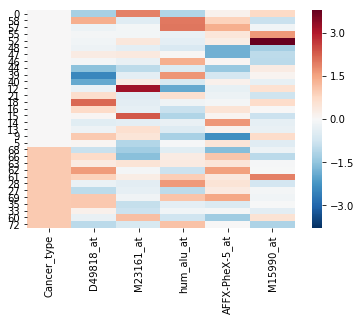

In [5]:
cols_of_interest = ["Cancer_type","D49818_at", "M23161_at", "hum_alu_at", "AFFX-PheX-5_at", "M15990_at"]
heat_df = data_train[cols_of_interest]
heat_df = heat_df.sort_values(by=["Cancer_type"])
sns.heatmap(heat_df)

* Kind of busy! Try examining genes individually.

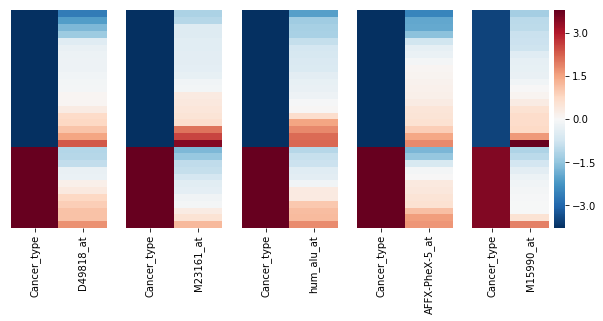

In [6]:
plt.figure(figsize=(10,4))
for i, col in enumerate(cols_of_interest[1:]):
    heat_df = heat_df.sort_values(by=["Cancer_type",col])
    if NORMALIZATION_STRATEGY==1:
        heat_df.loc[heat_df["Cancer_type"]==0,"Cancer_type"] = -3.5
        heat_df.loc[heat_df["Cancer_type"]==1,"Cancer_type"] = 3.5
    plt.subplot(1,5,i+1)
    if i<4:
        sns.heatmap(heat_df[["Cancer_type",col]], cbar=False)
    else:
        sns.heatmap(heat_df[["Cancer_type",col]], cbar=True)
    plt.yticks([])


* If the distribution of expression levels differs when Cancer_type=0 vs when Cancer_type=1, we argue that that gene may be useful in discriminating between cancer types.
* The distributions of gene expression for this subset look very similar across cancer types. M23161_at seems the most promising of the bunch.

#### 5. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors ...

first two principal components explained variance ratio = 0.280


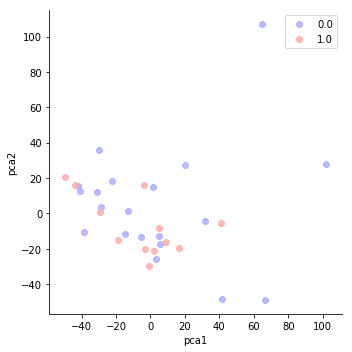

In [7]:
# split out target variable
X_train = data_train.iloc[:,1:]
y_train = data_train.iloc[:,0]
X_test = data_test.iloc[:,1:]
y_test = data_test.iloc[:,0]

# pca
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
print("first two principal components explained variance ratio = %0.3f" % np.sum(pca.explained_variance_ratio_))

# scatter plot
X_train_pca_df = pd.DataFrame(X_train_pca, columns=["pca1", "pca2"])
X_train_pca_df["Cancer_type"] = y_train.values
sns.lmplot(x="pca1", 
           y="pca2", 
           hue="Cancer_type", 
           data=X_train_pca_df, 
           fit_reg=False, 
           legend=False, 
           palette='bwr')
plt.legend();

# add a manual eyeballed decision boundary
# eyeball_decision = lambda x: -1-0.65*x 
# xToPlot = np.linspace(-60,60,100)
# plt.plot(xToPlot, 
#          [eyeball_decision(x) for x in xToPlot], 
#          ls='--', 
#          color='black',
#          label="eyeballed linear decision boundary")
# plt.xlim([min(X_train_pca[:,0])+1, max(X_train_pca[:,0])+1])
# plt.ylim([min(X_train_pca[:,1])+1, max(X_train_pca[:,1])+1])


#### ... How well do the top two principal components discriminate between the two classes?

* It's difficult to draw a decision boundary (even a non-linear one) that perfectly separates red from blue points. However, there’s clearly some useful info in these two components in terms of creating a classifier.

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `M23161_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



#### 1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at` ...

In [8]:
# add column to house intercept
X_train_wcons = sm.add_constant(X_train[["D29963_at"]])
X_test_wcons = sm.add_constant(X_test[["D29963_at"]])

# fit
ols = OLS(endog=y_train, exog=X_train_wcons).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Cancer_type   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.346
Date:                Wed, 01 Nov 2017   Prob (F-statistic):             0.0773
Time:                        23:38:37   Log-Likelihood:                -20.501
No. Observations:                  32   AIC:                             45.00
Df Residuals:                      30   BIC:                             47.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3750      0.084      4.473      0.000       0.204       0.546
D29963_at      0.1534      0.084      1.829      0.077      -0.018       0.325
==============================================================================
Omnibus:                       14.047   Durbin-Watson:                   0.443
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                3.932
Skew:                           0.498   Prob(JB):                        0.140
Kurtosis:                       1.601   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ... We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the ALL type cancer (class 1). Is there a problem with this interpretation?

* A simple ols model may yield predictions outside [0,1], which are not valid probabilities. 

#### 2. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

In [9]:
# predictions
y_hat_ols_train = ols.predict(X_train_wcons)
y_hat_ols_test = ols.predict(X_test_wcons)

# accuracy
print("ols single predictor accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_ols_train>0.5))
print("ols single predictor accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_ols_test>0.5))

ols single predictor accuracy in train = 0.719
ols single predictor accuracy in test = 0.829


#### 3. Next, fit a simple logistic regression model to the training set. ...

In [10]:
logreg = LogisticRegression(C=100000, fit_intercept=False)
logreg.fit(X_train_wcons, y_train)


LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### ... How does the training and test calssification accuracy of this model compare with the linear regression model?

In [11]:
y_hat_logreg_train = logreg.predict_proba(X_train_wcons)[:,1]
y_hat_logreg_test = logreg.predict_proba(X_test_wcons)[:,1]

# accuracy
print("logit single predictor accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_logreg_train>0.5))
print("logit single predictor accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_logreg_test>0.5))

logit single predictor accuracy in train = 0.719
logit single predictor accuracy in test = 0.829


* Logistic regression yields slightl better accuracy on train (0.78) but logit does better in test (0.805 vs 0.78).

* Note, by “accuracy” here, we just mean the percentage of y_train observations that are perfectly predicted by our model. 
* It’s not really needed for a two-class problem like this, but we can also calculate recall and precision for our logit classifier: 

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_hat_ols_train>0.5))

             precision    recall  f1-score   support

        0.0       0.70      0.95      0.81        20
        1.0       0.80      0.33      0.47        12

avg / total       0.74      0.72      0.68        32



#### 4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. ...

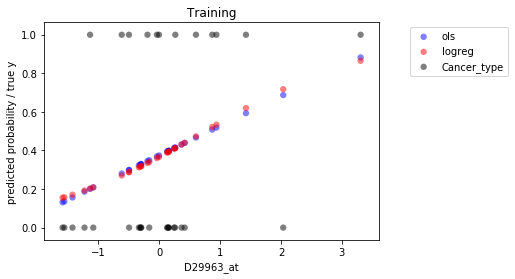

In [13]:
plt.scatter(X_train[["D29963_at"]], y_hat_ols_train, label="ols", c='blue', alpha=0.5, edgecolor='none', s=40)
plt.scatter(X_train[["D29963_at"]], y_hat_logreg_train, label="logreg", c='red', alpha=0.5, edgecolor='none', s=40)
plt.scatter(X_train[["D29963_at"]], y_train, label="Cancer_type", c='black', alpha=0.5, edgecolor='none', s=40)
plt.title("Training")
plt.ylabel("predicted probability / true y")
plt.xlabel("D29963_at")
if NORMALIZATION_STRATEGY==0:
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
plt.legend(bbox_to_anchor=(1.4,1))

#### ... Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

* Both ols and logistic regression appear to yield similar predicted probabilities. 
* So based on this figure, no one model appears preferable to the other.

## Part (c): Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

In [14]:
# starter code
from HW5_functions import visualize_prob

In [14]:
def visualize_prob(model, x, y, ax, jitter=True):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[np.where(y==1)]
    yneg = y_pred[np.where(y==0)]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    if jitter==False:
        pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'ALL')
        neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'AML')
    else:
        pos_handle = ax.plot(np.random.normal(loc=0, scale=0.05, size=npos), ypos[:,1], 'bx', label = 'ALL')
        neg_handle = ax.plot(np.random.normal(loc=0, scale=0.05, size=nneg), yneg[:,1], 'o', label = 'AML', mfc='none', mec='r')
    
    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])
    ax.set_xlim([-1,1])

#### 1. Next, fit a multiple logistic regression model with all the gene predictors from the data set. ...

In [15]:
logregmul = LogisticRegression(C=100000, fit_intercept=False)
X_train_mul_wcons = sm.add_constant(X_train)
X_test_mul_wcons = sm.add_constant(X_test)
logregmul.fit(X_train_mul_wcons, y_train)


LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### ... How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?

In [16]:
y_hat_logregmul_train = logregmul.predict_proba(X_train_mul_wcons)[:,1]
y_hat_logregmul_test = logregmul.predict_proba(X_test_mul_wcons)[:,1]

# accuracy
print("logit all predictors accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_logregmul_train>0.5))
print("logit all predictors accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_logregmul_test>0.5))


logit all predictors accuracy in train = 1.000
logit all predictors accuracy in test = 0.976


* accuracy in both training (1.00) and test (0.927) improves considerably with all genes vs a single gene.

#### 2. "Use the visualize_prob from HW5_functions.py to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. ... 

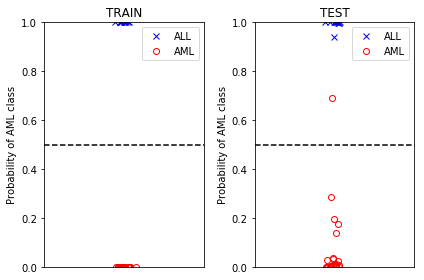

In [17]:
# set jitter = False to get results without modification
f, (ax1, ax2) = plt.subplots(1, 2)
visualize_prob(
    model=logregmul,
    x=X_train_mul_wcons,
    y=y_train,
    ax=ax1,
    jitter=True
)
ax1.set_title("TRAIN")
visualize_prob(
    model=logregmul,
    x=X_test_mul_wcons,
    y=y_test,
    ax=ax2,
    jitter=True
)
ax2.set_title("TEST")
plt.tight_layout()

#### ... Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

* In training the probabilities are either 1 or 0. In test probabilities a handful of predicted probabilities fall closer to 0.5. 
* For these points, we are unsure if we should predict $\hat{y}=0$ or $\hat{y}=1$.
* Furthermore, we can see one ALL case in test which a Bayes classifier would wrongly predict to be AML.

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [18]:
b_genes = logregmul.coef_[0]

In [19]:
iterations = 100

b_genes_boot = np.zeros((X_train_mul_wcons.shape[1],100))

for i in range(iterations):
    # sample with replacement from X_train
    boot_rows = np.random.choice(range(X_train_mul_wcons.shape[0]), size=X_train_mul_wcons.shape[0], replace=True)
    X_train_boot = X_train_mul_wcons.values[boot_rows]
    y_train_boot = y_train.values[boot_rows]

    # fit
    logregmul_boot = LogisticRegression(C=100000, fit_intercept=False)
    logregmul_boot.fit(X_train_boot, y_train_boot)
    b_genes_boot[:,i] = logregmul_boot.coef_


In [21]:
# construct confidence intervals
b_genes_ci_upper = np.percentile(b_genes_boot, 97.5, axis=1)
b_genes_ci_lower = np.percentile(b_genes_boot, 2.5, axis=1)
b_genes_ci_upper.shape, b_genes_ci_lower.shape, X_train_mul_wcons.shape[1]

((7130,), (7130,), 7130)

In [22]:
# ct significant predictors
sig_b_ct = 0

# if ci contains 0, then insignificant
for i in range(X_train_mul_wcons.shape[1]):
    if b_genes_ci_upper[i]<0 or b_genes_ci_lower[i]>0:
        sig_b_ct += 1

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, X_train_mul_wcons.shape[1]))

Significant coefficents at 5pct level = 1402 / 7130


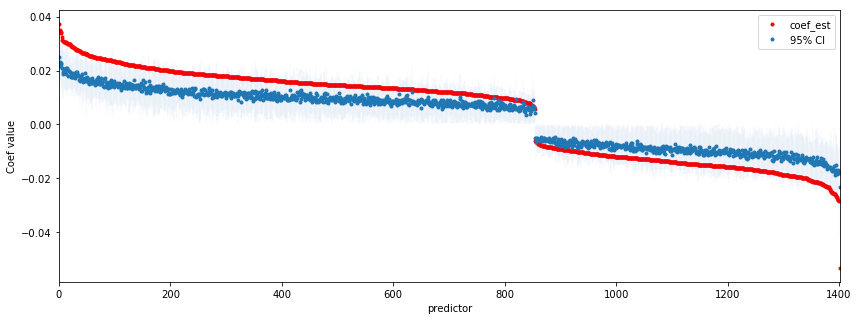

In [23]:
# this plot is not asked for; just for illustration
# to generate a dataframe of the significant predictors only
sig_b = []

# if ci contains 0, then insignificant
for i in range(X_train_mul_wcons.shape[1]):
    if b_genes_ci_upper[i]<0 or b_genes_ci_lower[i]>0:
        row={}
        row["gene"] = X_train_mul_wcons.columns[i]
        row["coef"] = b_genes[i]
        row["CI 2.5"] = b_genes_ci_lower[i]
        row["CI 97.5"] = b_genes_ci_upper[i]
        sig_b.append(row)
    
sig_b_df = pd.DataFrame(sig_b)
sig_b_df = sig_b_df.sort_values("coef", ascending=False)
sig_b_df[["gene","coef","CI 2.5","CI 97.5"]].head()

# plot
plt.figure(figsize=(14,5))
plt.errorbar(range(sig_b_df.shape[0]), 
             0.5*sig_b_df["CI 97.5"]+0.5*sig_b_df["CI 2.5"], 
             yerr=0.5*(sig_b_df["CI 97.5"]-sig_b_df["coef"])+0.5*(sig_b_df["coef"]-sig_b_df["CI 2.5"]),
             fmt='.',
             marker=None,
             elinewidth=0.05,
             label="95% CI"
         )
plt.scatter(range(sig_b_df.shape[0]), sig_b_df["coef"], color='red', label="coef_est", marker='.')
plt.xlim((0,sig_b_df.shape[0]))
plt.xlabel("predictor")
plt.ylabel("Coef value")
plt.legend()

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


#### 0. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

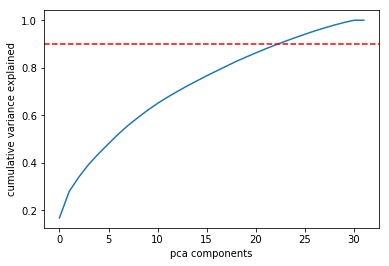

In [24]:
pca = PCA()
pca.fit(X_train)
var_c = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(len(var_c)), var_c)
plt.axhline(0.9,ls='--',color='red')
plt.xlabel("pca components")
plt.ylabel("cumulative variance explained");

In [25]:
n_components_pca = np.sum(var_c<0.9)
print("the first %i components explain %0.3f of variance" % (n_components_pca, var_c[n_components_pca]))

X_train_pca = pca.transform(X_train)[:,:n_components_pca]
X_test_pca = pca.transform(X_test)[:,:n_components_pca]

the first 23 components explain 0.911 of variance


In [31]:
pca.transform(X_train).shape, pca.transform(X_test).shape

((32, 26), (41, 26))

In [26]:
logregpca = LogisticRegression(C=100000, fit_intercept=True)
logregpca.fit(X_train_pca, y_train)
y_hat_pca_train = logregpca.predict_proba(X_train_pca)[:,1]
y_hat_pca_test = logregpca.predict_proba(X_test_pca)[:,1]


#### 1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?

In [27]:
# accuracy
print("pca 90pct + logit accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_pca_train>0.5))
print("pca 90pct + logit accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_pca_test>0.5))


pca 90pct + logit accuracy in train = 1.000
pca 90pct + logit accuracy in test = 0.951


* The accuracy in train and test is identical for pca + logreg vs logreg

#### 2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, ... 


In [28]:
from sklearn.model_selection import KFold

In [32]:
accuracy_train_cv = np.zeros((25,5))
accuracy_valid_cv = np.zeros((25,5))

fold_ctr = 0

for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train.index):
    # in general though its good for creating consistent psets, don't put seeds into kfold
    # split
    X_train_cv = X_train.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    # pca
    pca = PCA()
    pca.fit(X_train_cv)
    X_train_pca_cv = pca.transform(X_train_cv)
    X_valid_pca_cv = pca.transform(X_valid_cv)
    print('X_train_pca_cv.shape = {}'.format(X_train_pca_cv.shape))
    
    for comp in range(1,25):
        # fit logit
        logregcv = LogisticRegression(C=100000, fit_intercept=True)
        logregcv.fit(X_train_pca_cv[:,:comp], y_train_cv)
        
        # get predictions
        yhat_train_pca_cv = logregcv.predict(X_train_pca_cv[:,:comp])
        yhat_valid_pca_cv = logregcv.predict(X_valid_pca_cv[:,:comp])
        
        # get accuracy       
        accuracy_train_cv[comp,fold_ctr] = accuracy_score(y_train_cv, yhat_train_pca_cv)
        accuracy_valid_cv[comp,fold_ctr] = accuracy_score(y_valid_cv, yhat_valid_pca_cv)
        
    fold_ctr += 1


X_train_pca_cv.shape = (25, 25)
X_train_pca_cv.shape = (25, 25)
X_train_pca_cv.shape = (26, 26)
X_train_pca_cv.shape = (26, 26)
X_train_pca_cv.shape = (26, 26)


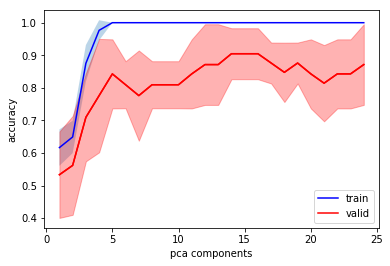

In [33]:
scores_train = np.mean(accuracy_train_cv, axis=1)[1:]
upp_train = scores_train + np.std(accuracy_train_cv, axis=1)[1:] # this doesn't constrain accuracy to be less than 1
low_train = scores_train - np.std(accuracy_train_cv, axis=1)[1:]
plt.plot(range(1,25), scores_train, color='blue', label='train')
plt.fill_between(range(1,25), low_train, upp_train, alpha=0.3);

scores_valid = np.mean(accuracy_valid_cv, axis=1)[1:]
upp_valid = scores_valid + np.std(accuracy_valid_cv, axis=1)[1:]
low_valid = scores_valid - np.std(accuracy_valid_cv, axis=1)[1:]
plt.plot(range(1,25), scores_valid, color='red', label='valid')
plt.fill_between(range(1,25), low_valid, upp_valid, alpha=0.3, color='red')
plt.plot(range(1,25), np.mean(accuracy_valid_cv, axis=1)[1:], color='red')

plt.xlabel("pca components")
plt.ylabel("accuracy")
plt.legend(loc=4)

In [35]:
scores_train

array([ 0.61661538,  0.64923077,  0.87538462,  0.97661538,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ])

In [38]:
np.argmax(scores_valid)

13

In [34]:
# choose optimum as smallest number of components "sufficiently" close to maximum validation accuracy
for i in range(len(scores_valid)):
    if np.max(scores_valid)-scores_valid[i]<0.002:
        n_components_optimal=i+1
        break

print("maximum validation accuracy using %i pca components" % n_components_optimal)


maximum validation accuracy using 14 pca components


In [39]:
logregpcacv = LogisticRegression(C=100000, fit_intercept=True)
logregpcacv.fit(X_train_pca[:,:n_components_optimal], y_train)
y_hat_pcacv_train = logregpcacv.predict_proba(X_train_pca[:,:n_components_optimal])[:,1]
y_hat_pcacv_test = logregpcacv.predict_proba(X_test_pca[:,:n_components_optimal])[:,1]


In [40]:
# accuracy
print("pca cv + logit accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_pcacv_train>0.5))
print("pca cv + logit accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_pcacv_test>0.5))


pca cv + logit accuracy in train = 1.000
pca cv + logit accuracy in test = 0.951


#### ... and comment on whether you get better test performance than the model fitted above (explain your observations).

* By running CV to choose the optimal number of components we get marginally worse performance on the test set.

#### 3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. ...

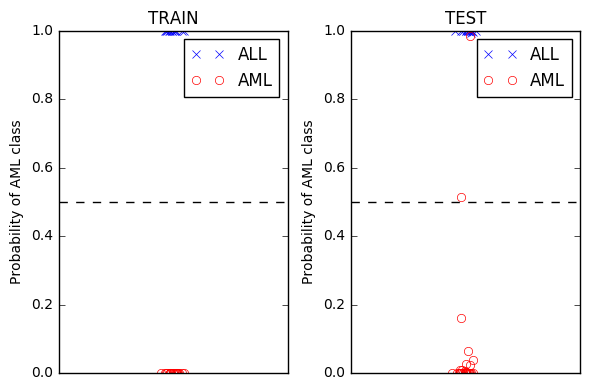

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2)
visualize_prob(
    model=logregpcacv,
    x=X_train_pca[:,:n_components_optimal],
    y=y_train,
    ax=ax1,
    jitter=True
)
ax1.set_title("TRAIN")
visualize_prob(
    model=logregpcacv,
    x=X_test_pca[:,:n_components_optimal],
    y=y_test,
    ax=ax2,
    jitter=True
)
ax2.set_title("TEST")
plt.tight_layout()

#### ... How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)?

* With the all-predictor logit model we risk finding spurious relationships between predictors and response.
* Using PCA we hope to find some lower dimensional representation of our predictors that retains our predictive power but hopefully is less vulnerable to overfitting. 
* In training, the pca+logit model is still able to exactly distinguish between ALL and AML. However we see our performance has not improved in test (by Bayes classifier, 2 AML cases would be misclassified as ALL and we still have a case where predicted probability of AML is very close to 0.5).

---
 

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

**(1) Suppose that the matrix norm is simply the squared dot product, namely**

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.

**Solution**

$$
\begin{align}
\parallel XQ-XQ_m \parallel ^2 &= (XQ-XQ_m)^T (XQ-XQ_m) \\
&= (Q^TX^T-Q_m^TX^T) (XQ-XQ_m) \\
&= Q^TX^TXQ - Q^TX^TXQ_m - Q_m^TX^TXQ + Q_m^TX^TXQ_m \\
&= Q^TX^TXQ - 2Q^TX^TXQ_m + Q_m^TX^TXQ_m
\end{align}
$$

**(2) Simplify your result from (1) based on properties of the matrices $Q$.**

**Solution**

$$
\begin{align}
\parallel XQ-XQ_m \parallel ^2 &= Q^TX^TXQ - 2Q^TX^TXQ_m + Q_m^TX^TXQ_m 
\end{align}
$$

Sub in: $X^TX = Q\Lambda Q^T$.

$$
\begin{align}
&= Q^TQ\Lambda Q^TQ - 2Q^TQ\Lambda Q^TQ_m + Q_m^TQ\Lambda Q^TQ_m
\end{align}
$$

$Q$ is an orthogonal matrix so $Q^T=Q^{-1}$.

$$
\begin{align}
&= \Lambda - 2\Lambda Q^TQ_m + Q^T_mQ \Lambda Q^T Q_m
\end{align}
$$


**(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely**

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

**Solution**

By the orthogonality of the vectors in $Q$:

$$
Q^TQ_m = Q_m^TQ = I_{mp} 
$$

where $I_{mp}$ is the identity matrix for the first $m$ rows and columns, and is 0 otherwise.

**(4) Use your results from (3) to finally fully simplify your expression from (2).**

**Solution**

$$
\begin{align}
\parallel XQ-XQ_m \parallel ^2 &= \Lambda - 2\Lambda Q^TQ_m + Q^T_mQ \Lambda Q^T Q_m \\
&= \Lambda - 2\Lambda I_{mp} + I_{mp} \Lambda I_{mp} \\
&= \Lambda - 2\Lambda_{mp} + \Lambda_{mp} \\
&= \Lambda - \Lambda_{mp} \\
\end{align}
$$

where $\Lambda_{mp}$ is the diagonal matrix of the first $m$ eigenvalues, and is 0 otherwise. 

**(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely**

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.

**Solution**

$$
\begin{align}
\parallel XQ-XQ_m \parallel ^2 &= \text{trace} (\Lambda - \Lambda_{mp}) \\
&= \sum_{i=m+1}^p \lambda_i
\end{align}
$$

**(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?**

**Solution**

* Reconstruction error is the sum of the eigenvalues of the components not selected during PCA.
* Our procedure of selecting the $m$ largest eigenvalues is equivalent to failing to select the smallest eigenvalues and thereby minimizes reconstruction error.